<u>**Making a path based on a polygon**</u>

**I. Create lat, lon positions of outer perimeter** <br>

1. Start tractor; Initiate GUI.  Press 'Start'; Wait for the green icon indicating RTK fix, then record all data.
2. Drive the location/site and save the data in rosbag including driving around obstacles. The suggestion is to drive the path twice.
3. In /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/ create a folder site1_20240513 to hold the working files
4. Copy the rosbag file into that folder
5. Follow, improve and merge instructions from 'Path Planning - Notes on Steps.odt' into this notebook<br>
   Determine the center point of the obstacle and the radius of the obstacle<br>
   Attribute the data into series of sites to cut and obstacles to avoid
   <br><br><br>
   Update the instructions in 'Path Planning - Notes on Steps.odt' because it is easier.  Later they can be pasted into this notebook.<br>
   Run python scripts from this notebook, but leave the code outside this notebook because it is easier to edit the code.  The exception may be in the case of plotting results.  That might have to be done inside this notebook.

**II. Create Outer Ring Path** <br>

See 'Path Planning - Notes on Steps.odt' <br><br>
Older notes<br>
Uplate locations DB with site info.  Open the file below and review each column of data.

In [2]:
# this is an older approach using the 'LOcations' Database 
# it is also an example of how to open a file from inside a Jupyter cell
# open and review the locations DB
!libreoffice --calc /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/paths_locations.csv

**Older Notes** <br>
*open the script and update hardcoding*

line 542 - location_name = 'Collins_Dr_62_Site_01'
line 567 & 568 - circle_center = (17.3, -9.1) ; radius = 2.4
line 575 & 576 - lookahead=2.5; speed=0.75
line 570  xy_file_adjusted_for_obstacles - this is out by the process so this should not have to change unless maybe the site changes.
line 571 finished_xy_file - you can leave this alone, just think through if you want to copy this file into the 'ready to test' folder
     = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_adjusted_for_obstacles.csv'
    = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/input_path.txt' 

In [19]:
import subprocess

# Full path to the subl command and the file you want to open
subl_path = "/snap/bin/subl"
file_path = "/home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/path_polygon_rings/path_ll2xy_2inner_rings_v4.py"

# Running the command
subprocess.run([subl_path, file_path])


CompletedProcess(args=['/snap/bin/subl', '/home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/path_polygon_rings/path_ll2xy_2inner_rings_v4.py'], returncode=0)

**These are old instructions - See 'Path Planning - Notes on Steps.odt' to make ring paths** <br>

Run the script below. It will:<br>
1. Extract the lat/lon data from rosbag files using 'gps_data = convert_gps_to_cartesian(latlon_file_path, origin_lat, origin_lon)'
2. Create inner rings using 'ring_path = create_inner_rings(gps_data, num_inner_rings, path_size, start_point, xy_file_name)'
3. Look for intersections of obstacle using 'intersections, segments, indices, circle_segments = find_intersections_with_circle(xy_file_name, circle_center, radius, num_circle_points, xy_file_adjusted_for_obstacles)'
4. Finish the outer perimiter path (i.e. calc angle, add lookahead and speed) using 'update_df_with_angle_lookahead_speed(xy_file_adjusted_for_obstacles, lookahead, speed, finished_xy_file)'

In [11]:
# run script to create outer rings
!python3 /home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/path_polygon_rings/path_ll2xy_2inner_rings_v4.py
#
# NOTE: There are plots created that are not displayed when running this inside of Jupyter

running script: path_ll2xy_2inner_rings_v4.py
reading file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01.csv and calculating coordinates
There are 1383 records in gps_data from the .csv file
There are 1383 records in polygon points extracted from gps_data
Original polygon written to file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_0.csv
Ring 5 written to file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_5.csv
Ring 4 written to file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_4.csv
Ring 3 written to file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_3.csv
Ring 2 written to file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_2.csv
Ring 1 written to file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_1.csv
Paths written to /home/tractor

**III. Create Stripe Path**<br>
**Step 1 - Load initial variables**<br>
Read the innermost polygon of the field.  

In [3]:
#
# INPUT VARIABLES - MUST RUN BEFORE RUNNING CELL BELOW
#
mower_cutting_width = 0.9
#original_polygon_file = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_5.csv'
xlsx_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx'

#
# File for the first iteration of the Boustrophedon line segments
boustrophedon_line_segments = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/Site_01_boustrophedon_line_segments.csv'
# /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513
# File for calculating the additional points to make a continuous coverage map
trimmed_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/Site_01_boustrophedon_line_segments_trimmed.csv'
#
# Input file for adding angles  
file_for_adding_angles = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/Site_01_boustrophedon_line_segments_trimmed_points_1to4_in_sequence.csv'
input_for_generator_program = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/Site_01_boustrophedon_line_segments_input_path_for_generator.txt' 


# Libraries used below
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, LineString, MultiLineString
from shapely.affinity import rotate
from matplotlib import pyplot as plt, patheffects
import os
import csv
import math

import dubins

import time

**Step 2 - Read .csv file and plot field**<br>
Read the polygon of the field and display it for visual confirmation

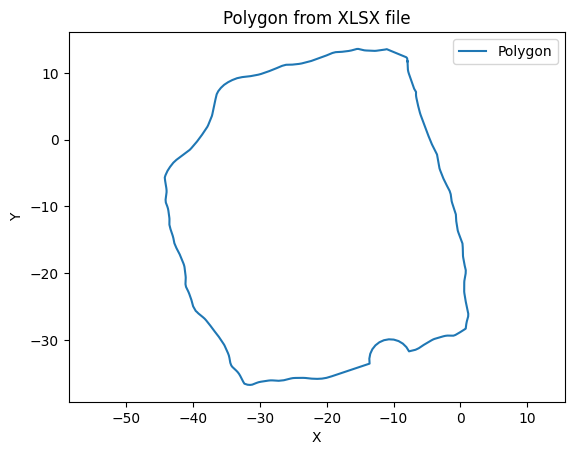

In [4]:

data = pd.read_excel(xlsx_file_path, sheet_name='UpdatedPath')  # Read the XLSX file
data = data[data['Path_Index'] == 0]  # Filter rows where 'Path_Index' equals 0
x = data["X"].tolist()  # Extract the X and Y coordinates
y = data["Y"].tolist()
x.append(x[0])  # Close the polygon by adding the first point to the end
y.append(y[0])

# Plot the polygon
plt.plot(x, y, label="Polygon")
plt.xlabel("X")  # Set labels and title
plt.ylabel("Y")
plt.title("Polygon from XLSX file")
plt.legend()  # Add legend and show plot
plt.axis('equal')
plt.show()

**Step 3 - Create initial Boustrophedon path**<br>

I have the script below and 'path_boustrophedon_coverage_variable_degree2.py' to create Boustrophedon line segments for the initial coverage map.  Adjust the angle for the cut path you prefer.

Try adding a cell to execute the python script from here.  This notebook separates the function of creating the line segments and trimming the line segments.

In [5]:
#
# run script to create initial Boustrophedon coverage path
!python3 /home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_boustrophedon_coverage_variable_degree4.py
#

running script: path_boustrophedon_coverage_variable_degree4.py
reading the file:  /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx
Total line segments: 28
First few lines of boustrophedon line segments
LINESTRING (-39.69202135542127 -25.524806154320945, -41.14387070380955 -21.30832948398516)
LINESTRING (-36.97887584249062 -28.46157926755133, -44.00746727102931 -8.049067586050192)
LINESTRING (-32.76501996303397 -35.75673175148741, -43.601763515956954 -4.284543246505142)
LINESTRING (-30.79553284485298 -36.5337640654109, -42.37086399361514 -2.9165614304760403)
LINESTRING (-29.226373968369884 -36.14815874515448, -41.014664038052274 -1.9124784955850185)
eoj


reading the file:  /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx


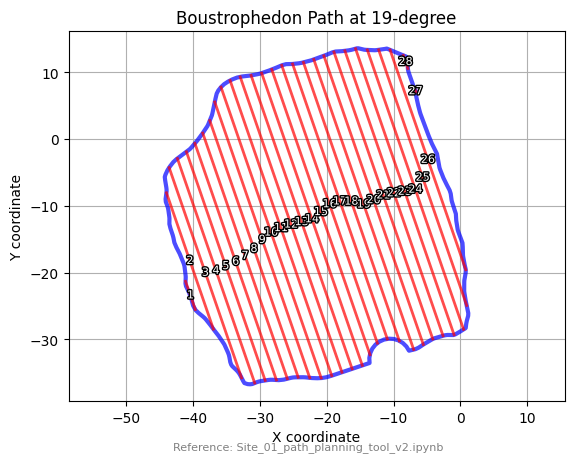

In [15]:
import pandas as pd
from shapely.geometry import Polygon, LineString
from matplotlib import pyplot as plt, patheffects
import os

def read_inner_ring(xlsx_file_path):
    # Read the specified sheet from the Excel file
    df = pd.read_excel(xlsx_file_path, sheet_name='UpdatedPath')
    # Filter the data to include only points with Path_Index = 0
    filtered_df = df[df['Path_Index'] == 0]
    # Create a list of points (tuples) from the filtered data
    polygon_points = list(zip(filtered_df['X'], filtered_df['Y']))
    # Return the polygon created from these points
    return Polygon(polygon_points)

def read_boustrphdn_segments(xlsx_file_path):
    # Read the specified sheet from the Excel file
    df = pd.read_excel(xlsx_file_path, sheet_name='boustrphdn_segmnts')
    # Create a list of LineStrings from the data
    path_lines = []
    for _, row in df.iterrows():
        path_lines.append(LineString([(row['x1'], row['y1']), (row['x2'], row['y2'])]))
    return path_lines

def plot_path(polygon, path_lines, degree):
    fig, ax = plt.subplots()
    x, y = polygon.exterior.xy
    ax.plot(x, y, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

    for idx, line in enumerate(path_lines):
        x, y = line.xy
        ax.plot(x, y, color='red', linewidth=2, alpha=0.7, zorder=2)
        # Position the text in the center of the line segment
        text_x = (x[0] + x[1]) / 2
        text_y = (y[0] + y[1]) / 2
        ax.text(text_x, text_y, str(idx + 1), fontsize=8, verticalalignment='center',
                horizontalalignment='center', color='white', path_effects=[
                patheffects.withStroke(linewidth=2, foreground="black")])

    ax.set_title(f'Boustrophedon Path at {degree}-degree')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.grid(True)
    plt.axis('equal')
    # Get the absolute path of the current script
    filepath = 'Site_01_path_planning_tool_v2.ipynb'
    plt.figtext(0.5, 0.01, f'Reference: {filepath}', ha='center', fontsize=8, color='gray')
    plt.show()

# Path to the Excel file
xlsx_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx'  
print("reading the file: ", xlsx_file_path)
angle_degrees = 19

# Read the polygon data from the Excel file
polygon = read_inner_ring(xlsx_file_path)

# get the boustrophedon segments from the Excel file
path_lines = read_boustrphdn_segments(xlsx_file_path)

# Plot the path
plot_path(polygon, path_lines, angle_degrees)

**Step 4 - Trim the initial Boustrophedon path to remove partial segments**<br>
This code defines the input and output file paths, and the number of lines to remove from the beginning and end. It then reads the CSV file line by line, skipping the specified number of lines at the beginning. The remaining lines are stored in a list. Finally, the code iterates through the list and removes the specified number of lines from the end. The trimmed data is then written to a new file with the word "trimmed" added to the original filename.


In [10]:
#
# Update the input file name and the number of line segments to remove from the beginning and end of the data
# run script to trim the initial Boustrophedon coverage path
!python3 /home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_boustrophedon_trim_segments.py
#


Reading sheet: boustrphdn_segmnts from file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx
Total rows before trim: 29
Total rows after trim: 25
Trimmed data saved to sheet: boustrphdn_trimmed in file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx


**Step 5 - Visualize the coverage map for confirmation**<br>
This code does the following:
* Reads the CSV file and store the data in a list named `data`.
* Extract `x1`, `y1`, `x2`, and `y2` values into separate lists.
* Plot the starting and ending points as colored dots and connect them with line segments.

Reading sheet: boustrphdn_trimmed from file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx


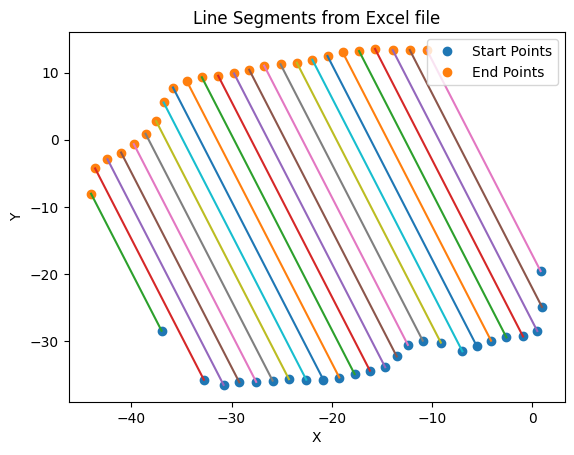

In [11]:
import openpyxl
import matplotlib.pyplot as plt

# Define input file path and sheet name
xlsx_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx'
input_sheet_name = 'boustrphdn_trimmed'

# Load the workbook and select the input sheet
print(f"Reading sheet: {input_sheet_name} from file: {xlsx_file_path}")
workbook = openpyxl.load_workbook(xlsx_file_path)
input_sheet = workbook[input_sheet_name]

# Read data from the input sheet
data = list(input_sheet.iter_rows(values_only=True))

# Extract line segment coordinates
x1 = [float(row[0]) for row in data]
y1 = [float(row[1]) for row in data]
x2 = [float(row[2]) for row in data]
y2 = [float(row[3]) for row in data]

# Plot line segments
plt.plot(x1, y1, 'o', label='Start Points')
plt.plot(x2, y2, 'o', label='End Points')
for i in range(len(x1)):
    plt.plot([x1[i], x2[i]], [y1[i], y2[i]], label=None)

# Add labels and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Line Segments from Excel file")

# Add legend and show plot
plt.legend()
plt.show()




**Step 6 - Visualize how the right angles are calculated**<br>
I need to calculate additional points to define the u-turn points.  This step is actually performed two steps below.  The cell below is only for informational purposes so you can see the calculation using hard coded data which is hopefully easier to understand.

<img src="images/dubins_image1.png" alt="Dubins Path" width="300px">
You can see for the'start points', which are at the bottom of the image, I need to calculate the point to the left of the start point. For the 'end points', which are at the top of the image, I need to calculate the point to the right of the end point.  These points make a right triangle.

The very first starting point will be ignored as this is the entry point into the continuous path.  Given the assumption is the continuous path is moving from left to right, the new bottom point to the left of the original line segment end point will have an x-axis value less than the the original line segment end point x value.  The new top point to the right of the top point will have an x-axis value greater than the the original line segment top point x value.  

The first small script below is simply a test showing how to use two hard coded points to create a third point and to plot it.  <br><br>

Note there is a change for 'preference' to  'greater' and 'less' to see how the hypotenuse line will shift sides. 


The solution for the hypotenuse with 'greater' preference is: larger on the x-axis
The angle 90.0 is within 0.05 degrees of 90 degrees.


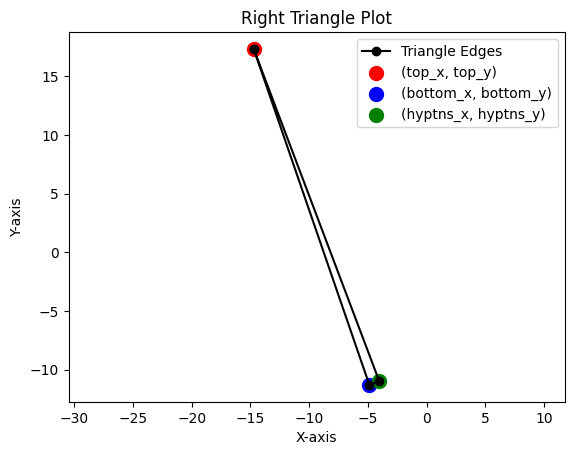

The solution for the hypotenuse with 'less' preference is: smaller on the x-axis
The angle 90.0 is within 0.05 degrees of 90 degrees.


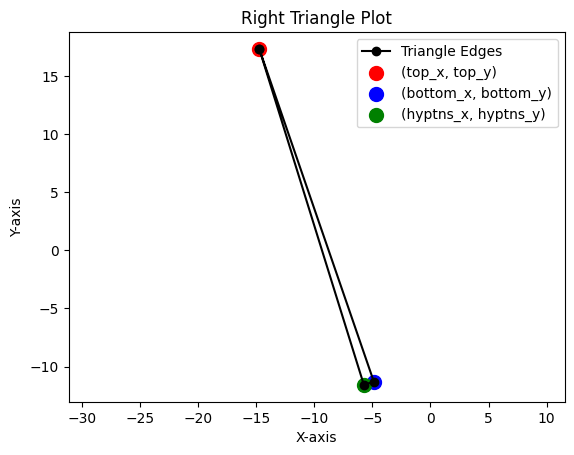

End of script


In [23]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_x3_y3_solutions(x1, y1, x2, y2, length=0.9):
    """
    Calculate two possible coordinates of the third point (x3, y3) to form a right triangle
    with the line segment from (x1, y1) to (x3, y3) as the hypotenuse. This function returns
    both solutions, allowing for a choice where x3 can be greater than x2.
    """
    dx = x2 - x1
    dy = y2 - y1

    # Normalize the direction vector (dx, dy)
    norm = np.sqrt(dx**2 + dy**2)
    dx /= norm
    dy /= norm

    # Rotate 90 degrees in both directions and scale by the desired length
    dx1, dy1 = -dy * length, dx * length  # First solution
    dx2, dy2 = dy * length, -dx * length  # Second solution

    # Calculate (x3, y3) for both solutions
    x3_1 = x2 + dx1
    y3_1 = y2 + dy1
    x3_2 = x2 + dx2
    y3_2 = y2 + dy2

    return (x3_1, y3_1), (x3_2, y3_2)

def choose_x3_y3_solution(x2, y2, x3_1, y3_1, x3_2, y3_2, preference='less'):
    """
    Choose the (x3, y3) point based on the preference.

    Parameters:
    - x3_1, y3_1, x2, y2, x3_2, y3_2: Coordinates of x3 and y3 from the first and second solutions, and x2, y2.
    - preference: Can be 'greater' or 'less' to choose which 'side' the hypotenuse should be on in relation to the x-axis.

    Returns:
    - x3, y3: The chosen coordinates of x3 and y3.
    - solution: A string indicating which solution was chosen.
    """
    if preference == 'greater':
        if x3_1 > x2:
            return x3_1, y3_1, "larger on the x-axis"
        else:
            return x3_2, y3_2, "smaller on the x-axis"
    else:  # preference is 'less'
        if x3_1 < x2:
            return x3_1, y3_1, "larger on the x-axis"
        else:
            return x3_2, y3_2, "smaller on the x-axis"

def angle_check(x1, y1, x2, y2, x3, y3, tolerance=0.05):
    """
    Check if the angle at (x2, y2) is close to 90 degrees within a specified tolerance.
    """
    # Vectors (x1,y1)->(x2,y2) and (x3,y3)->(x2,y2)
    vector1 = [x1 - x2, y1 - y2]
    vector2 = [x3 - x2, y3 - y2]

    # Dot product and magnitudes of vectors
    dot_product = np.dot(vector1, vector2)
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    # Calculate the angle in degrees
    angle = np.arccos(dot_product / (magnitude1 * magnitude2)) * (180 / np.pi)

    # Check if the angle is within the tolerance of 90 degrees
    if np.abs(angle - 90) > tolerance:
        print(f"Error: The angle {round(angle,2)} is not within 0.1 degrees of 90 degrees.")
    else:
        print(f"The angle {round(angle,2)} is within {tolerance} degrees of 90 degrees.")

def plot_triangle(x1, y1, x2, y2, x3, y3):
    plt.figure()

    # Plot the triangle lines first
    plt.plot([x1, x2, x3, x1], [y1, y2, y3, y1], '-o', color='black', label='Triangle Edges')

    # Set different colors for each point with increased size
    plt.scatter(x1, y1, color='red', s=100, label='(top_x, top_y)')
    plt.scatter(x2, y2, color='blue', s=100, label='(bottom_x, bottom_y)')
    plt.scatter(x3, y3, color='green', s=100, label='(hyptns_x, hyptns_y)')

    # Labels, title, and equal aspect ratio
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Right Triangle Plot')
    plt.legend()
    plt.axis('equal')
    plt.show()

# Test points
top_x, top_y = -14.72, 17.32
bottom_x, bottom_y = -4.87, -11.29

# Calculate both possible (x3, y3) points
(hyptns_x_opt_a, hyptns_y_opt_a), (hyptns_x_opt_b, hyptns_y_opt_b) = calculate_x3_y3_solutions(top_x, top_y, bottom_x, bottom_y)

# Run with 'greater' preference
hyptns_x, hyptns_y, solution = choose_x3_y3_solution(bottom_x, bottom_y, hyptns_x_opt_a, hyptns_y_opt_a, hyptns_x_opt_b, hyptns_y_opt_b, preference='greater')
print(f"The solution for the hypotenuse with 'greater' preference is: {solution}")
angle_check(top_x, top_y, bottom_x, bottom_y, hyptns_x, hyptns_y)
plot_triangle(top_x, top_y, bottom_x, bottom_y, hyptns_x, hyptns_y)

# Run with 'less' preference
hyptns_x, hyptns_y, solution = choose_x3_y3_solution(bottom_x, bottom_y, hyptns_x_opt_a, hyptns_y_opt_a, hyptns_x_opt_b, hyptns_y_opt_b, preference='less')
print(f"The solution for the hypotenuse with 'less' preference is: {solution}")
angle_check(top_x, top_y, bottom_x, bottom_y, hyptns_x, hyptns_y)
plot_triangle(top_x, top_y, bottom_x, bottom_y, hyptns_x, hyptns_y)

print("End of script")


**Step 7 - Calculate the additional points to make a continuous coverage map**<br>
Use the approach crafted above to calculate the third point of a right triangle and iterate over the .csv file to calculate all the points in the full set of line segments.   

The overview of the program is:<br>
1. Read the data into a DataFrame<br>
2. Assign the values for (x1, y1), (x2, y2) named (bottom_x, bottom_y), (top_x, top_y)<br>
3. Calculate the hypotenuse for the 'bottom' point<br>
4. Calculate the hypotenuse for the 'top' point<br>
5. Store the points in a DataFrame <br>
6. Move to the next line segment until complete<br>
7. Once the loop is complete write the dataframe to a new sheet.<br><br>


In [25]:
#
# Update the input file name and run script to create a new Boustrophedon coverage path ready to calculate Dubins paths
!python3 /home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_create_right_triangles.py
#

Results saved to sheet: coverage_path in file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx


**Step 8 - Plot points for visual verification**<br>
Now I need to plot the points for some visual verification.  The plot shows the connected path of points. For each row in the ,csv file has a sequence of 4 points.  The path will be from Point 1 to Point 2 to Point 3 to Point 4 and is connected by a green line, creating a continuous path that represents the sequence of movements for the entire .csv file.

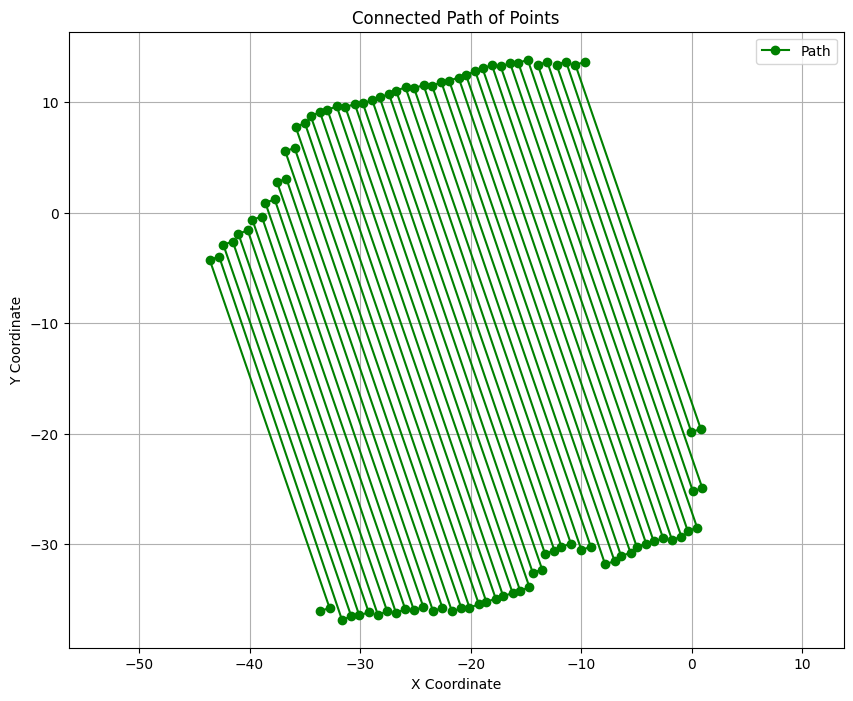

In [28]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt

# Define the Excel file path and sheet name
xlsx_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx'
sheet_name = 'coverage_path'

# Load the provided Excel sheet into a DataFrame without headers
df = pd.read_excel(xlsx_file_path, sheet_name=sheet_name, header=None)

# Manually assign the column names
df.columns = ['Point_1_x', 'Point_1_y', 'Point_2_x', 'Point_2_y', 'Point_3_x', 'Point_3_y', 'Point_4_x', 'Point_4_y']

# Initialize lists to hold the x and y coordinates in the order of plotting
x_coords = []
y_coords = []

# Loop through the DataFrame and add the coordinates in the required order
for index, row in df.iterrows():
    x_coords.extend([row['Point_1_x'], row['Point_2_x'], row['Point_3_x'], row['Point_4_x']])
    y_coords.extend([row['Point_1_y'], row['Point_2_y'], row['Point_3_y'], row['Point_4_y']])

# Now plot the points and the connecting green line
plt.figure(figsize=(10, 8))

# Plot the red and blue dots for points 1 and 2
# plt.scatter(df['Point_1_x'], df['Point_1_y'], color='red', label='Point 1')
# plt.scatter(df['Point_2_x'], df['Point_2_y'], color='blue', label='Point 2')

# Connect the points with a green line
plt.plot(x_coords, y_coords, 'go-', label='Path')

# Set the x and y axis limits to be equal
plt.axis('equal')

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Connected Path of Points')
plt.legend()
plt.grid(True)
plt.show()


**Step 9 - Reformat the data to prepare for angle calculations**<br>
Now I need to calculate the angle each segment is travelling to be able to use that as input into the path generator routine and then run the path generator routine to create an input file, or a file to save in the "Ready for Testing" folder.  To do that I first need to reformat the 1 row, 4 point x, y data into a series of rows with just one x, y data point on each row.

In [39]:
#
# Read the data from the specified sheet, reformat it, and save the results to a new sheet named coverage_path_refrmttd in the same Excel file.
# This is in support of creating a Boustrophedon coverage path that uses Dubins (i.e. key hole) u-turns. 
#
!python3 /home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_coverage_path_reformat.py
#

List of x, y points ready for angle calculations. Use sheet 'coverage_path_refrmttd' in the Excel file '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx' as input.


**Step 10 - Calculate the angle between points, add  lookahead and speed**<br>
Prepare the data for input into the final generation step by calculating the andgle and add speed and lookahead.

In [40]:
#
# Read the x, y data from the specified sheet; Add the angle, speed, and lookahead to the data then save the results to a new sheet the same Excel file.
#
!python3 /home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_add_angle_to_xy.py
#

Calculating angles
Length of angles list 96, length of DataFrame 96
Adding lookahead and speed
Writing to Excel file
Data published to sheet: path_with_angle in file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx


**Step 11 - Generate path using Dubins shortest path**<br>
Read in a series of waypoints from the file waypoint.txt and expand them based on the step size and angle using the Dubins shortest path library.  The practical 
use of this is to have straight segments followed by a u-turn that is shaped like a key hole.

For an explanation for the input file can be found in the document 'Path Planning - Creating a waypoint plan using path_generator.odt' which can be 
found at https://github.com/jones2126/ros1_lawn_tractor_ws


references:
- credit to Matt Droter for an initial outline script
- https://pypi.org/project/dubins/

In [41]:
#
!python3 /home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_create_dubins.py
#

done with generate_drive_path
Data published to sheet: path_dubins in file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx
done with calculate_curvature_and_output_excel
Output file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx
Record count: 8102 turning_radius: 1.3 step_size: 0.3
eoj


**Step 12 - Visually check the stripes**<br>
THIS STEP RUNS FOR ~ 70 SECONDS on my HP G-645 - look at the script 'path_test_plot_before_running_simulation.py'.  It plots more points, but does not take more than 10 seconds.

Plot the path.  Keep the import statement and filename within this function in case you want to copy the code and run it outside of Jupyter.  That will allow me to zoom in on points if need.

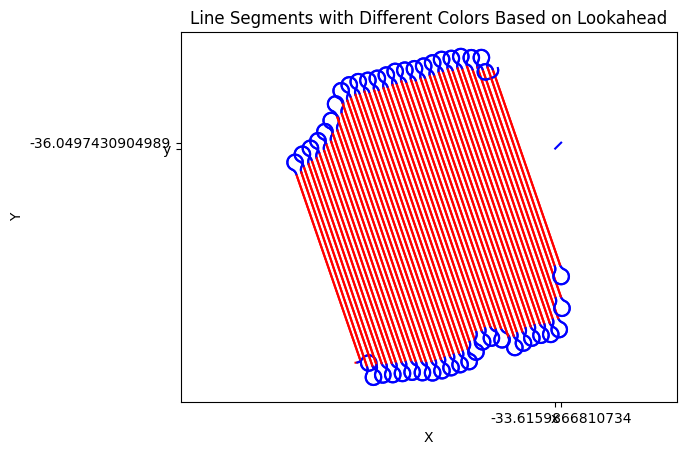

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to read data from an Excel sheet
def read_data(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
    df.columns = ['x', 'y', 'theta', 'lookahead', 'speed']
    points = df[['x', 'y', 'lookahead']].values.tolist()
    return points

# Function to plot the data
def plot_data(points):
    for i in range(len(points) - 1):
        x1, y1, lookahead1 = points[i]
        x2, y2, lookahead2 = points[i + 1]

        # Choose color based on lookahead value
        color = 'red' if lookahead1 == 2.5 else 'blue'

        # Plotting the line segment
        plt.plot([x1, x2], [y1, y2], color=color)

    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Line Segments with Different Colors Based on Lookahead')
    plt.axis("equal")
    # Show the plot
    plt.show()

# Main
file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx'
sheet_name = 'path_dubins'
data_points = read_data(file_path, sheet_name)
plot_data(data_points)

The above plot is close, but the first waypoint (-33.6159, -36.0497) is plotting as a disconnected line segment so I need to clean up the start and end and confirm the sequence (i.e. are the points in the top right or bottom left the first points?).

**Step 13 - Visually check the outer path and the stripes together**<br>
This is simply a visualization step to review the paths.  The input files have the x, y, theta, lookahead and speed as columns and are therefore ready to be input files to pure_pursuit.cpp

Open the script and update hardcoding for filepath names**<br>

The 'stripe' path is output from <u>Step 11 - Generate path using Dubins shortest path</u> above.  In the Jupyter cell there is a statement 'output_file_waypoints = working_directory + "test_generator_output.txt"' which appends text to the working directory.  The full name is printed when the cell finishes execution.  That name should be used for the 'blue path' filename. 

The ring path is output from script 'path_ll2xy_2inner_rings_v4.py'.  There is a variable 'finished_xy_file' that defines this file.  So whatever name is used there should be used for the 'green path' filename.

In [21]:
import subprocess

# Full path to the subl command and the file you want to open
subl_path = "/snap/bin/subl"
file_path = "/home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_test_plot_before_running_simulation.py"

# Running the command
subprocess.run([subl_path, file_path])

CompletedProcess(args=['/snap/bin/subl', '/home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_test_plot_before_running_simulation.py'], returncode=0)

**Step 14 - Visualize combined paths**<br>
In a seperate terminal window run <br> $ python3 /home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_test_plot_before_running_simulation.py
<br><br>
Currently it will generate the following visual: <br><br>
![Incorrect Overlay](https://drive.google.com/uc?id=1rHrDPdMz7_RZwtQR3S_FCPUzPz1pdej8)
<br>
Consider the following changes:
1. Four of the stripes need to be shortened to avoid the obstacle circle
2. Where the blue and green lines overlap is 'waste' in that it would lead to going over the same path twice.  I'm thinking to only run the two most outer rings and add more stripes to eliminate the white space after testing.
3. Stripes can be added to the beginning and end to reduce the white space<br> The file boustrophedon_line_segments is created in Step 3.  You **cannot** simply go back to <u>Step 4 - Trim the initial Boustrophedon path to remove partial segments</u> and adjust the lines to be trimmed. Step 3 uses the 5th ring as input to create the line segments and for some reason it does not believe there is a lot of white space that is unobstructed.  

**Changing the length of the line segments**<br>
I previously wrote this script, /home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_test_adjust_line_segment_length.py

It takes as input:
1. The output file name: uturn_points_csv = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/path_uturn_adjusted.csv'
2. The input file name: ods_file_path = '~/project_notes/paths/Collins_Dr_62/Site_01_boustrophedon_w_formulas_v1.ods'
3. length_to_shorten = -3.0  # using a negative number will extend the line (i.e. make it longer)
4. starting_row_of_data = 9


The program above plots the provided point and the new point

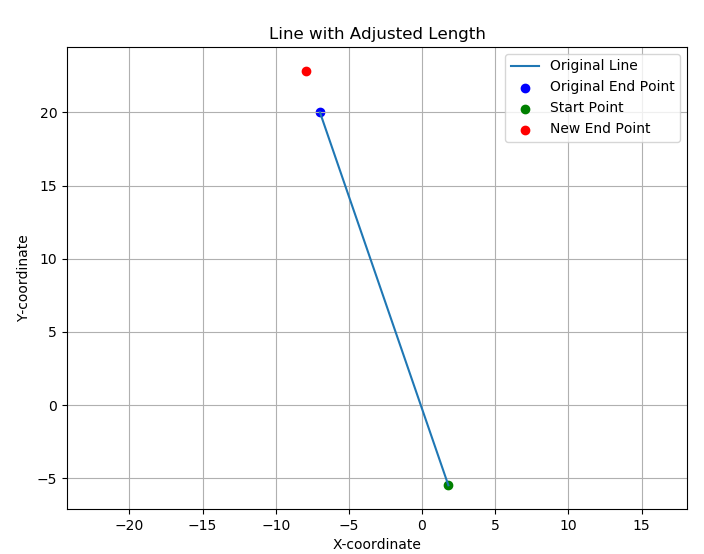

I need to know which line segments to shorten or extend.  One of the programs plots that.  I should be able to calculate this either by using the straight line segments or the u-turns or both.  Start with the straight line segments.  Where is the current line segment intersection performed?

This is the 'shortening' program: path_test_adjust_line_segment_length.py
The program for determining intersections is: path_ll2xy_2inner_rings_v4.py; What are the inputs and outputs?
